Please follow the instructions in the /data/readme.md for downloading the images prior to running this notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn import metrics
from keras.optimizers import SGD

import os, sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# create datagen preprocessing step for testing data
test_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

# assign relative file pathing to train and test data
train_path = os.path.join(os.pardir, os.pardir, 'data/train')
test_path = os.path.join(os.pardir, os.pardir, 'data/test')

In [3]:
# Flow holdout images in batches of 32 using test_datagen generator

image_size=224
batch_size=32
test_generator = test_datagen.flow_from_directory(
                test_path, # Source directory for the holdoutn images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary',
                shuffle=False)

Found 627 images belonging to 2 classes.


In [4]:
# load the pretrained neural network
model = load_model('bigdatamodel.h5')

W0416 16:24:23.300559 4593540544 deprecation.py:323] From /Users/kyledecember1/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0416 16:24:23.799638 4593540544 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


In [5]:
# illustrate the confusion matrix 
predictions = []
for x in model.predict(test_generator):
    for z in x:
        predictions.append(np.round(z))
        
metrics.confusion_matrix(test_generator.classes,predictions)

array([[104, 131],
       [  1, 391]])

In [6]:
# initiate explainer from LIME for insight on what features the model is using

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(test_generator[-2][0][0], 
                                         model.predict,
                                         hide_color=0,
                                         num_samples=1000)

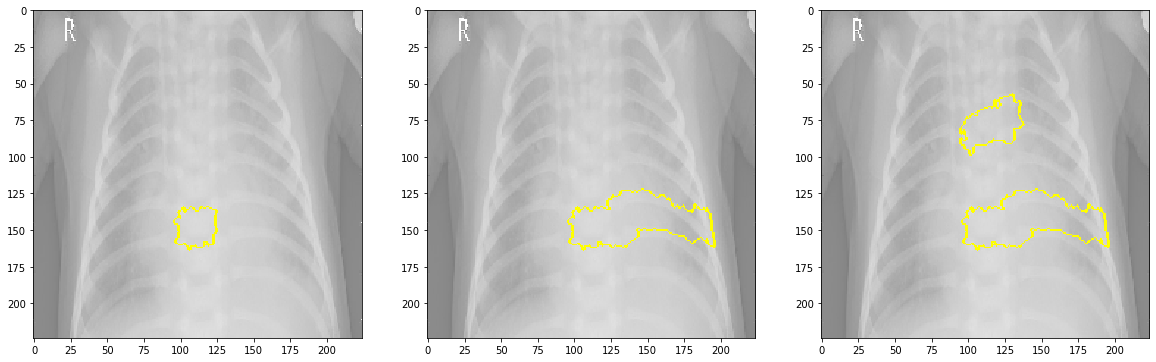

In [7]:
# visualize the areas of the image being focused by the model

fig, axes = plt.subplots(ncols=3, figsize=(20,30))

for feats in range(3):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=feats+1, 
                                            hide_rest=False)
    axes[feats].imshow(mark_boundaries(temp / 2 + 0.5, mask))

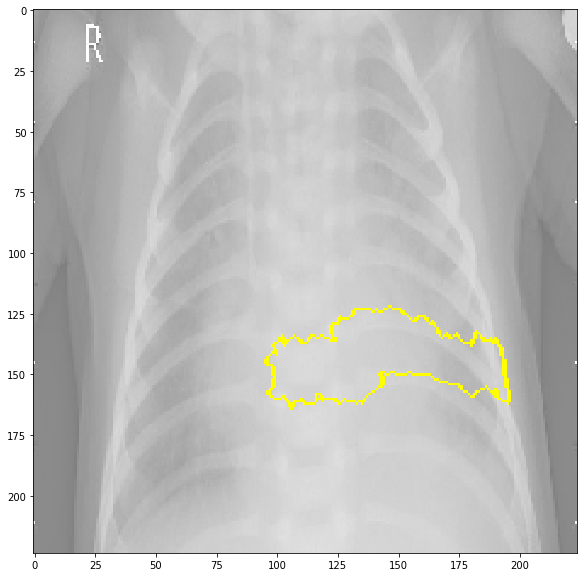

In [8]:
# zoom in on the top 2 most influential reasons

fig, ax = plt.subplots(figsize=(10,10))

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=2, 
                                            hide_rest=False)
ax.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [10]:
predictions = model.predict_generator(generator=test_generator)
y_pred = (predictions>0.5).astype(int)
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

NameError: name 'itertools' is not defined

<Figure size 432x288 with 0 Axes>

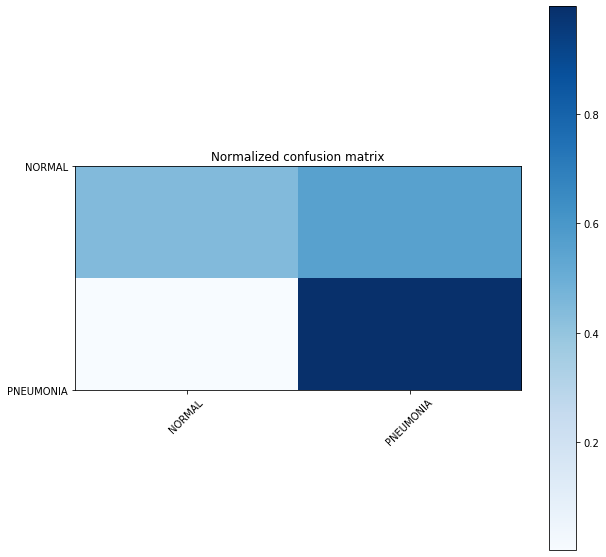

In [12]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [21]:
# compute
acc = metrics.accuracy_score(test_generator.labels, y_pred)
f1 = metrics.f1_score(test_generator.labels, y_pred)
recall = metrics.recall_score(test_generator.labels, y_pred)
precision = metrics.precision_score(test_generator.labels, y_pred)

print (f"Accuracy: {round(acc,3)}")
print (f"F1 Score: {round(f1,3)}")
print (f"Recall: {round(recall, 3)}")
print (f"Precision: {round(precision,3)}")

Accuracy: 0.789
F1 Score: 0.856
Recall: 0.997
Precision: 0.749
